In [1]:
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (15.0, 5.0)
import numpy as np

In [1]:
#write a function to visualise the order book events which takes time periods, and price range as arguments.
#write a function visualise the order book heat map.
#write a function plot the best ask and best bid price along with the trade events.
#writing these three functions can help with the visualisation on a larger scale.
#document this code well enough, we will make it a markdown format to be displayed on my personal website.

In [22]:
file = 'BTC.csv'
data = pd.read_csv(file, parse_dates=['time'], index_col="time",low_memory = False)
data['time'] = data.index

In [23]:
first_day =  data['time'].min()
last_day = data['time'].max()
print(first_day, last_day)
print(last_day-first_day)

2017-07-21 08:52:06.163000 2017-07-21 13:38:22.846000
0 days 04:46:16.683000


In [24]:
something = data.query("type == 'done' and side == 'sell' and reason == 'canceled'")
print(len(something))

372476


Time at which the number of events reached the maximum  6


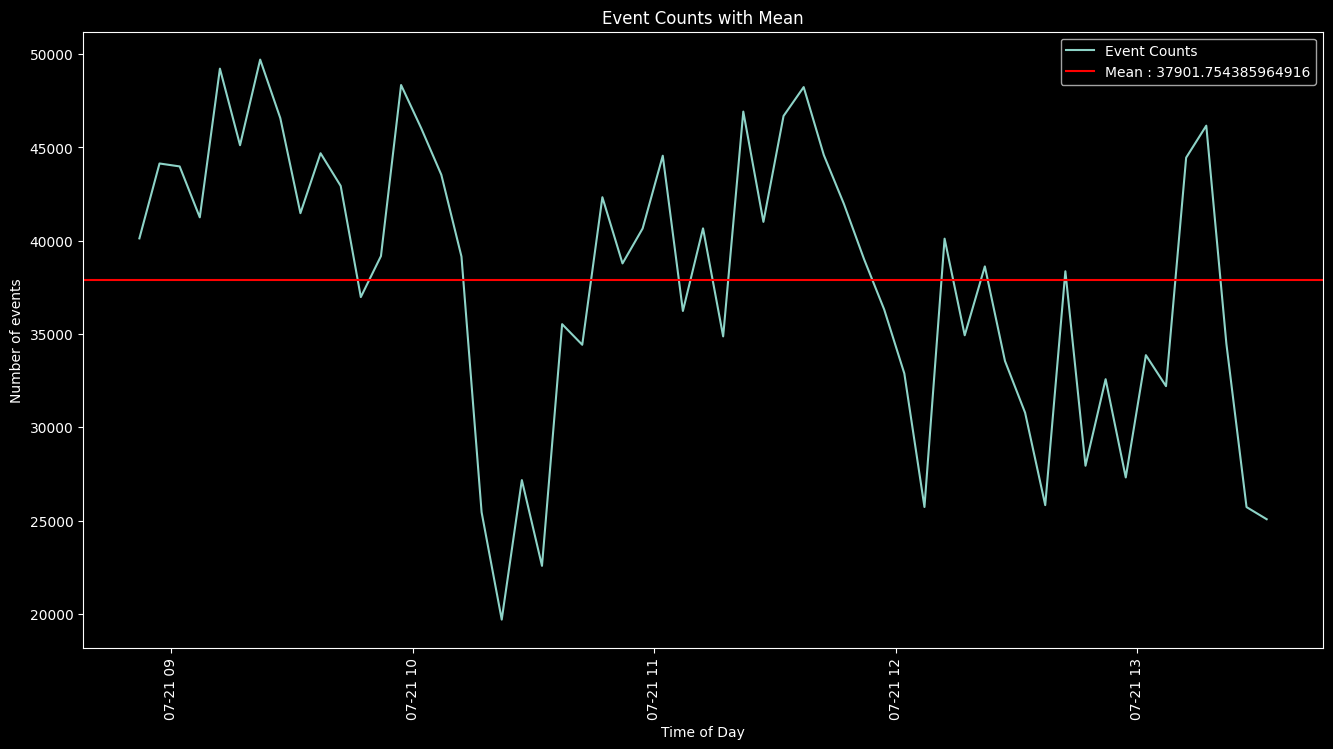

In [25]:


# making sure that the column is in the desired date-time format
data['time'] = pd.to_datetime(data['time'])

# making time intervals, or bins
time_intervals = pd.date_range(start=data['time'].min(), end=data['time'].max(), freq='5T')

# now the timestamps are put into these bins
data['time_interval'] = pd.cut(data['time'], bins=time_intervals, labels=time_intervals[:-1], include_lowest=True)

# now a new series is made which has the corresponding counts for a given timestamp
event_counts = data.groupby('time_interval')['time'].size().reset_index()
event_counts.columns = ['time_interval', 'event_count']

# computing the mean to plot the mean
mean_event_count = event_counts['event_count'].mean()

print('Time at which the number of events reached the maximum ', event_counts['event_count'].idxmax())


plt.figure(figsize=(16, 8))
plt.plot(event_counts['time_interval'], event_counts['event_count'], label='Event Counts')
plt.axhline(y=mean_event_count, color='r', label=f'Mean : {mean_event_count}')
plt.title('Event Counts with Mean')
plt.xlabel('Time of Day')
plt.xticks(rotation='vertical')
plt.ylabel('Number of events')
plt.style.use('dark_background')
plt.legend()
plt.show()

In [26]:
print("There are {:,} trades".format(data.shape[0]))

There are 2,169,450 trades


In [27]:
print("There are {:,} orders".format(data.order_id.nunique()))

There are 723,880 orders


In [28]:

# Get the order_ids of canceled orders
canceled_orders = data[(data['type'] == 'done') & (data['reason'] == 'canceled')]

# Get the order_ids that have match messages
matched_order_ids = data[data['type'] == 'match']['order_id']

# Identify flashed orders: canceled orders that have no matches and remaining size > 0
flashed_orders = canceled_orders[~canceled_orders['order_id'].isin(matched_order_ids) & (canceled_orders['remaining_size'] > 0)]

color_map = {'buy': 'blue', 'sell': 'red'}
flashed_orders['color'] = flashed_orders['side'].map(color_map)

print(f"There are {len(flashed_orders)} flashed orders")


There are 714648 flashed orders


In [29]:
# Get the order_ids of open orders
open_order_ids = data[data['type'] == 'open']['order_id']

# Filter the data to include only the open orders
open_orders_data = data[data['order_id'].isin(open_order_ids)]

# Get the resting orders
resting_orders = open_orders_data[(open_orders_data['type'] == 'open') | 
                                  ((open_orders_data['type'] == 'match') & (open_orders_data['remaining_size'] > 0))]

print(f"There are {len(resting_orders)} resting orders" ) 

There are 718925 resting orders


Number of canceled orders: 13606
Number of incoming orders: 13709


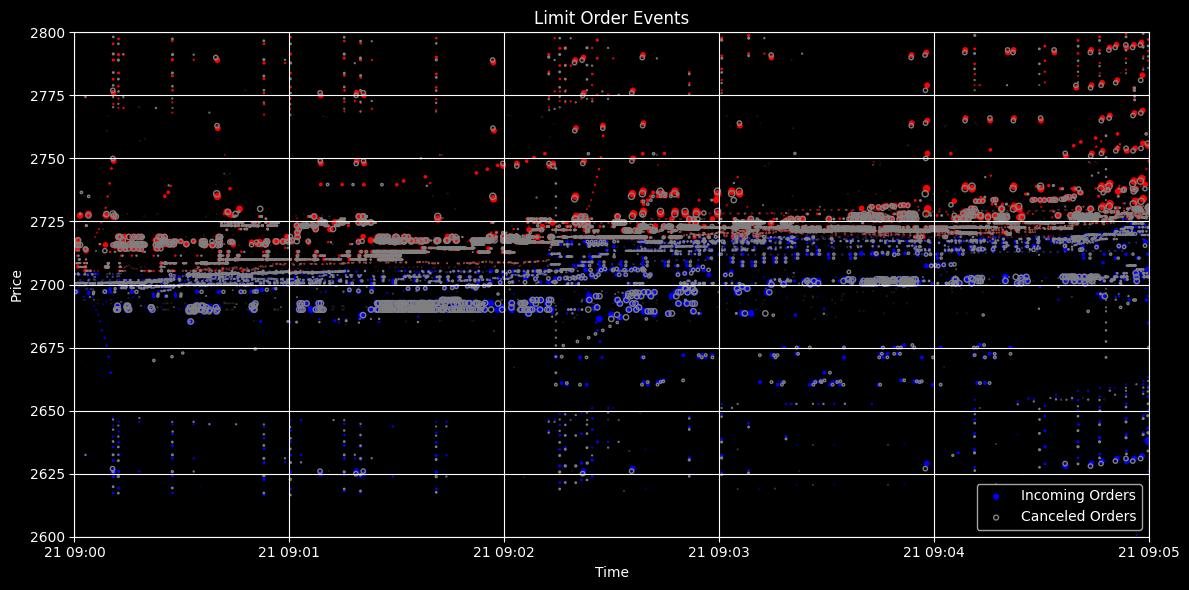

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_limit_order_events(data, start_time, end_time, min_price, max_price):
    # Convert 'time' column to datetime
    data['time'] = pd.to_datetime(data['time'])
    
    start_time_dt = pd.to_datetime(start_time)
    end_time_dt = pd.to_datetime(end_time)
    
    # Filter data based on time and price range
    filtered_data = data[(data['time'] >= start_time) & (data['time'] < end_time)]
    filtered_data = filtered_data[(filtered_data['price'] >= min_price) & (filtered_data['price'] <= max_price)]
    
    # Map 'side' to colors
    color_map = {'buy': 'blue', 'sell': 'red'}
    filtered_data['color'] = filtered_data['side'].map(color_map)
    
    # Determine marker size
    filtered_data['marker_size'] = filtered_data['remaining_size'].astype(float)
    
    # Get the order_ids of canceled orders
    canceled_orders = filtered_data[(filtered_data['type'] == 'done') & (filtered_data['reason'] == 'canceled')]
    print(f"Number of canceled orders: {len(canceled_orders)}")
    
    # Separate incoming orders (open)
    incoming_orders = filtered_data[filtered_data['type'] == 'open']
    print(f"Number of incoming orders: {len(incoming_orders)}")
    
    if filtered_data.empty:
        print("No data available within the specified time range and price.")
    else:
        # Proceed with plotting
        plt.figure(figsize=(12, 6))
        
        # Plot incoming orders (opaque circles)
        plt.scatter(
            x=incoming_orders['time'],
            y=incoming_orders['price'],
            color=incoming_orders['color'],
            s=incoming_orders['marker_size'],
            edgecolors=incoming_orders['color'],
            facecolors=incoming_orders['color'],
            alpha=1,
            label='Incoming Orders'
        )
        
        # Plot canceled orders (empty circles)
        plt.scatter(
            x=canceled_orders['time'],
            y=canceled_orders['price'],
            color=canceled_orders['color'],
            s=canceled_orders['marker_size'],
            edgecolors='grey',
            facecolors='none',
            alpha=1,
            label='Canceled Orders'
        )
        
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.title('Limit Order Events')
        plt.ylim(min_price, max_price)
        plt.xlim(start_time_dt, end_time_dt)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

plot_limit_order_events(data, '2017-07-21 09:00:00.000000', '2017-07-21 09:05:00.000000', 2600, 2800)


In [38]:
start_time_dt = pd.to_datetime('2017-07-21 09:00:00.000000')
end_time_dt = pd.to_datetime( '2017-07-21 09:05:00.000000')
    
# Filter data based on time and price range
filtered_data = data[(data['time'] >= start_time_dt) & (data['time'] < end_time_dt)]
filtered_data = filtered_data[(filtered_data['price'] >= 2600) & (filtered_data['price'] <= 2800)]
# Get the order IDs and timestamps of canceled orders
canceled_orders = filtered_data[(filtered_data['type'] == 'done') & (filtered_data['reason'] == 'canceled')][['order_id', 'time']]

# Get the order IDs and timestamps of incoming (open) orders
incoming_orders = filtered_data[filtered_data['type'] == 'open'][['order_id', 'time']]

# Group the incoming orders by order_id and get the minimum time for each order
first_open_times = incoming_orders.groupby('order_id')['time'].min()

# Filter the canceled orders to only include those where the first open time is within the time interval
canceled_orders = canceled_orders[canceled_orders['order_id'].isin(first_open_times[first_open_times.between(start_time_dt, end_time_dt)].index)]
# Count the number of canceled orders
common_count = len(canceled_orders['order_id'].unique())

print(f"Number of canceled orders that were opened within the same time interval: {common_count}")

Number of canceled orders that were opened within the same time interval: 13400


Now we will visualize the fleeting orders in this time period, so for that we will get the deleted volume on the x-axis and the time on the vertical axis. Since we do not have an extensive amount of data, we would stick with timestamps with hourly or minute frequencies. What is so striking about this visualisation is the geometeric appearence of the orders, If there were more data points then it would have been much clearer. Because, then we would be able to plot it and see it in the daily scale.

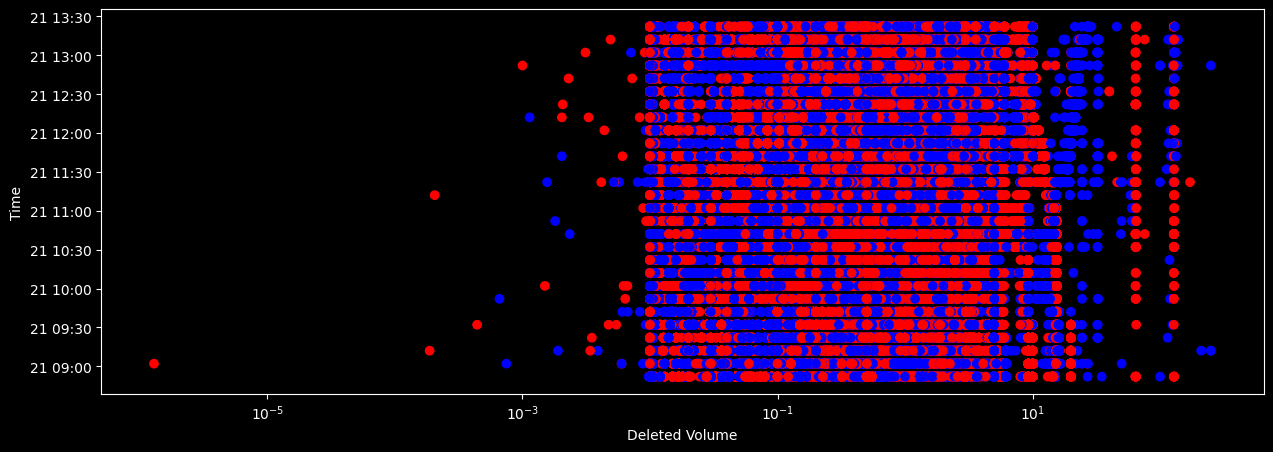

In [32]:
time_intervals = pd.date_range(start=flashed_orders['time'].min(), end=flashed_orders['time'].max(), freq='10min')
flashed_orders['time_interval'] = pd.cut(flashed_orders['time'], bins=time_intervals, labels= time_intervals[:-1] , include_lowest= True)
plt.scatter(flashed_orders['remaining_size'], flashed_orders['time_interval'],c=flashed_orders['color'], label = 'Fleeting orders')
plt.xlabel('Deleted Volume')
plt.ylabel('Time')
plt.xscale('log')
plt.show()


This geometeric appearence of the data can also be visualised in another way if we plot it with the axes swapped. 

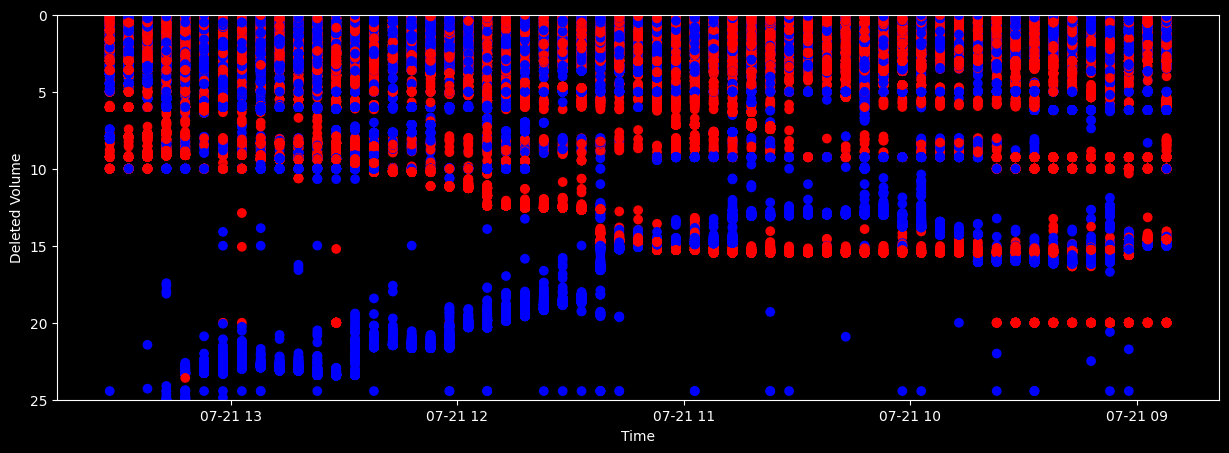

In [33]:
time_intervals = pd.date_range(start=flashed_orders['time'].min(), end=flashed_orders['time'].max(), freq='5T')

flashed_orders['time_interval'] = pd.cut(flashed_orders['time'], bins=time_intervals, labels=time_intervals[:-1], include_lowest=True)

# Set the desired y-axis limits
plt.ylim(0, 25)

plt.scatter(flashed_orders['time_interval'], flashed_orders['remaining_size'], c=flashed_orders['color'], label='Fleeting orders')

plt.xlabel('Time')
plt.ylabel('Deleted Volume')

# Swap the x and y axes
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

# Set the x-axis to log scale
plt.style.use('dark_background')
plt.show()

The available volume at any given price level is the sum of the volume from the individual orders enqueued at that price. 

In [15]:
def compute_volume(time_period_start:str, time_period_end:str, price):
    new_time = pd.to_datetime(time_period_start)
    end_time = pd.to_datetime(time_period_end)
    filtered_data = resting_orders[((resting_orders['time'] > new_time) & (resting_orders['time'] < end_time)) & (resting_orders['price'] == price)]
    cumulative_volume = filtered_data['remaining_size'].sum()
    return cumulative_volume

c= compute_volume('2017-07-21 09:00:00.000000', '2017-07-21 12:00:00.000000', price= 2715)
print(c)


98.46068558


Now let us plot the (the most common way of doing it so) order book volume as the cumulative sum of the volume on either side of the order book.

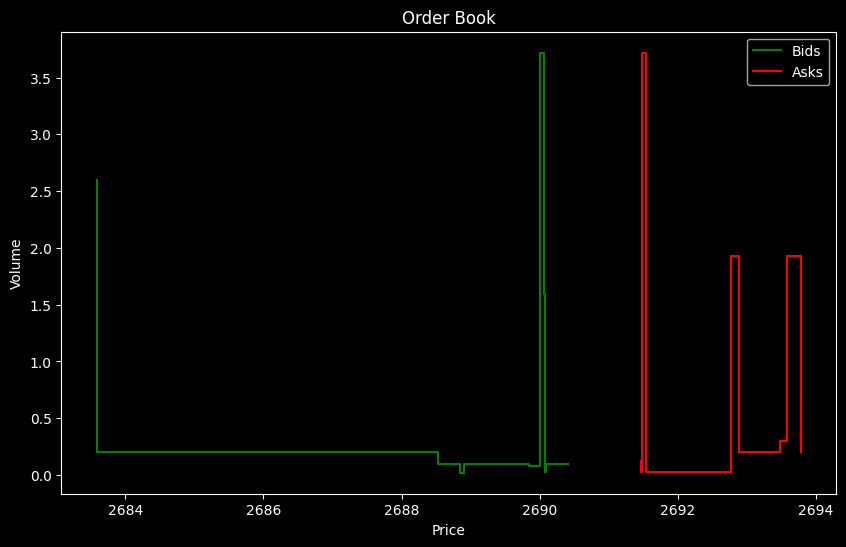

In [16]:
import matplotlib.pyplot as plt

new_time = pd.to_datetime('2017-07-21 11:00:00.000')
end_time = pd.to_datetime('2017-07-21 11:00:00.500')
data = resting_orders[(resting_orders['time'] >= new_time) & (resting_orders['time'] <= end_time)]

# Separate bids and asks
bids = data[data['side'] == 'buy'].sort_values(by='price', ascending=False)
asks = data[data['side'] == 'sell'].sort_values(by='price', ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bids
bid_prices = bids['price'].tolist()
bid_volumes = bids['remaining_size'].tolist()
ax.step(bid_prices, bid_volumes, where='post', color='green', label='Bids')

# Plot asks
ask_prices = asks['price'].tolist()
ask_volumes = asks['remaining_size'].tolist()
ax.step(ask_prices, ask_volumes, where='post', color='red', label='Asks')

ax.set_xlabel('Price')
ax.set_ylabel('Volume')
ax.legend()
ax.set_title('Order Book')

plt.show()

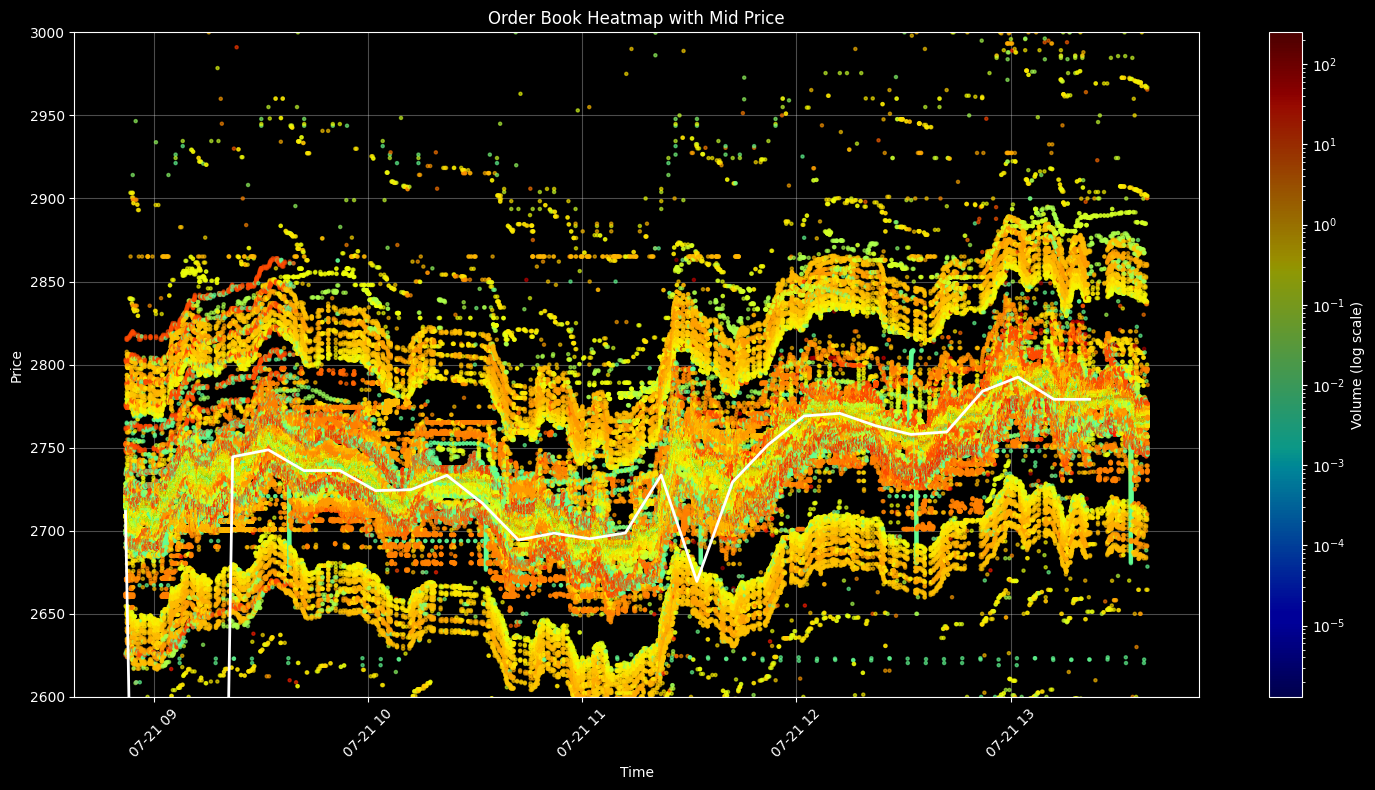

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

# Create time intervals and group data
time_intervals = pd.date_range(start=data['time'].min(), end=data['time'].max(), freq='10min')
data['time_interval'] = pd.cut(data['time'], bins=time_intervals, labels=time_intervals[:-1], include_lowest=True)

# Calculate best bids, asks, and mid prices
bids = data[data['side'] == 'buy'].groupby('time_interval')['price'].max()
asks = data[data['side'] == 'sell'].groupby('time_interval')['price'].min()
best_prices = pd.DataFrame({'best_bid': bids, 'best_ask': asks})
best_prices['mid_price'] = (best_prices['best_bid'] + best_prices['best_ask']) / 2

# Create the plot
plt.figure(figsize=(15, 8))

# Plot mid price as a white line
plt.plot(best_prices.index, best_prices['mid_price'], color='white', linewidth=2, zorder=3)

# Scatter plot for volume
scatter = plt.scatter(data['time'], data['price'], 
                      c=data['remaining_size'], s=5, 
                      cmap='jet', norm=LogNorm(), alpha=0.6, zorder=2)

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Volume (log scale)')

# Set y-axis limits and ticks
y_min = 2600
y_max = 3000
plt.ylim(y_min, y_max)


plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Order Book Heatmap with Mid Price')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, zorder=1)
plt.tight_layout()
plt.show()

In [48]:
#make time intervals
#get the market mid price
#then make buckets of 20 to upwards and downwards
def plot_order_book_depth(time, bid_data, ask_data):
    fig, ax = plt.subplots(figsize=(15, 8))
    
    
    # Create color map
    colors = plt.cm.coolwarm(np.linspace(0, 1, 20))
    
    # Plot ask side (positive values)
    cumulative_ask = np.zeros(len(time))
    for i in range(20):
        ax.fill_between(time, cumulative_ask, cumulative_ask + ask_data[i], 
                        color=colors[i], alpha=0.7)
        cumulative_ask += ask_data[i]

    cumulative_bid = np.zeros(len(time))
    for i in range(20):
        ax.fill_between(time, -cumulative_bid, -(cumulative_bid + bid_data[i]),
                        color = colors[19-i], alpha = 0.7)
        cumulative_bid += bid_data[i]

    ax.set_xlabel('Time')
    ax.set_ylabel('Volume')
    ax.set_title('Cumulative Order Book Depth')
    
    # Set y-axis to symmetric around 0
    y_max = max(cumulative_ask.max(), cumulative_bid.max())
    ax.set_ylim(-y_max, y_max)
    
    # Add a line at y=0 for clarity
    ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
    
    plt.tight_layout()
    plt.show()




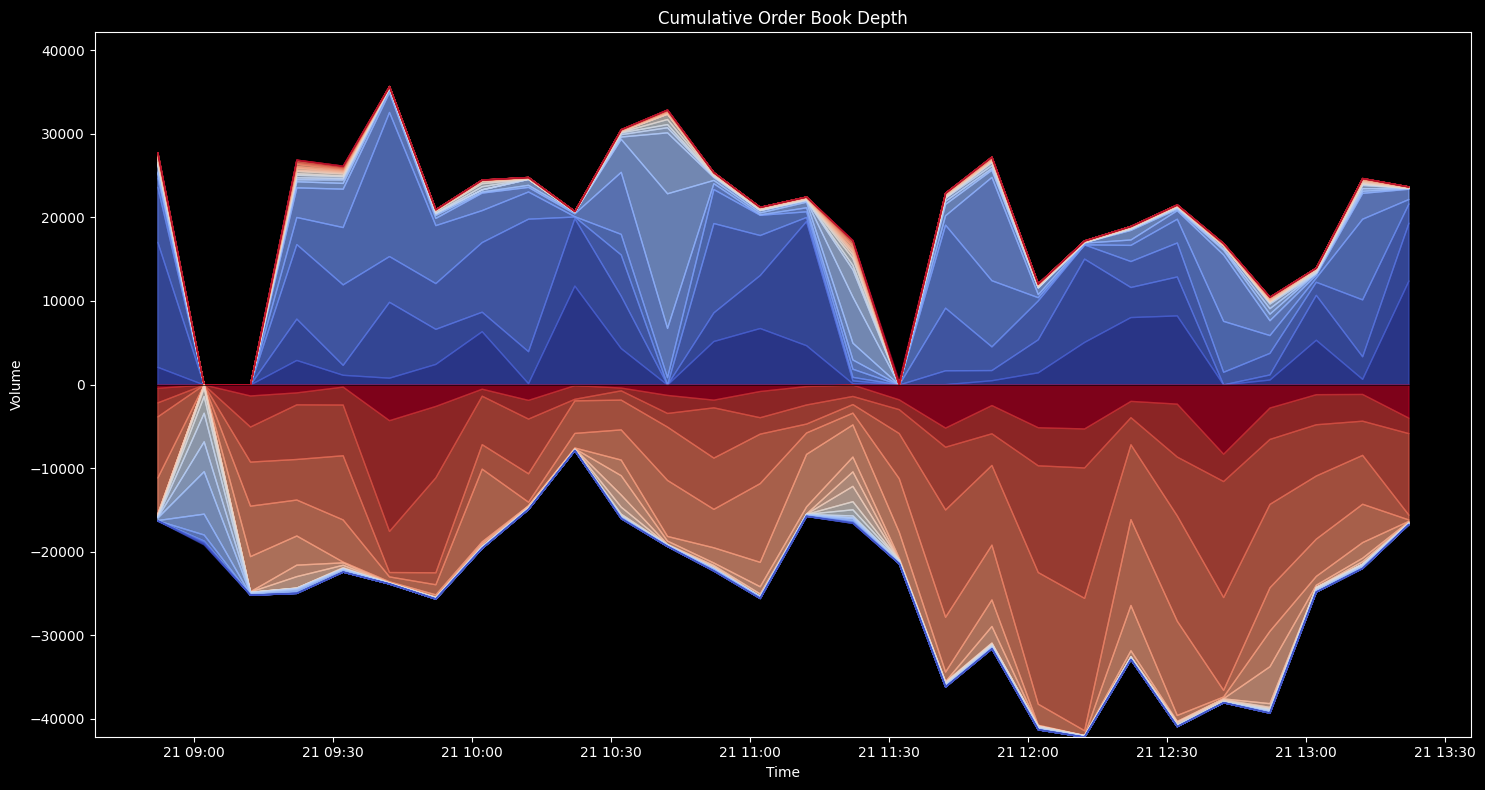

In [53]:
import numpy as np
import pandas as pd


# Step 1: Create time array
time = best_prices.index

# Step 2: Define the price buckets (20 for bid side, 20 for ask side)
num_buckets = 20
bucket_size = 0.0025  # 25 basis points

# Step 3: Calculate volumes for each bucket at each time point
def calculate_bucket_volumes(group, best_price, is_bid):
    volumes = np.zeros(num_buckets)
    for i in range(num_buckets):
        if is_bid:
            lower = best_price * (1 - (i + 1) * bucket_size)
            upper = best_price * (1 - i * bucket_size)
        else:
            lower = best_price * (1 + i * bucket_size)
            upper = best_price * (1 + (i + 1) * bucket_size)
        
        volumes[i] = group[(group['price'] >= lower) & (group['price'] < upper)]['size'].sum()
    return volumes

bid_data = []
ask_data = []

for t in time:
    group = data[data['time_interval'] == t]
    
    best_bid = best_prices.loc[t, 'best_bid']
    best_ask = best_prices.loc[t, 'best_ask']
    
    bid_group = group[group['side'] == 'buy']
    ask_group = group[group['side'] == 'sell']
    
    bid_volumes = calculate_bucket_volumes(bid_group, best_bid, True)
    ask_volumes = calculate_bucket_volumes(ask_group, best_ask, False)
    
    bid_data.append(bid_volumes)
    ask_data.append(ask_volumes)

bid_data = np.array(bid_data).T  # Transpose to match the required format
ask_data = np.array(ask_data).T  # Transpose to match the required format

# Now you can use these with the plotting function
plot_order_book_depth(time, bid_data, ask_data)

In [ ]:
imp = ['price', 'remaining_size', 'side', 'type', 'reason', 'order_id', 'time']
data[imp].head(10)


,price,remaining_size,side,type,reason,order_id,time
time,,,,,,,
2017-07-21 11:00:00.008,2691.54,0.030000,sell,open,NaN,dc12e105-0a97-4215-a04f-7f9ffe67249f,2017-07-21 11:00:00.008
2017-07-21 11:00:00.014,2693.59,1.925972,sell,open,NaN,d205ebef-c135-4c76-bb6f-cce5ec03fdc5,2017-07-21 11:00:00.014
2017-07-21 11:00:00.073,2692.78,1.925972,sell,open,NaN,7b3ee744-6b07-4fc8-8e3b-f673e178613a,2017-07-21 11:00:00.073
2017-07-21 11:00:00.149,2690.07,3.718180,buy,open,NaN,5b163fae-180a-4cfd-bf87-8e32e51e5bc6,2017-07-21 11:00:00.149
2017-07-21 11:00:00.149,2693.59,1.925972,sell,open,NaN,d26b6c0d-d9f6-46e7-a439-4f3194a4af7f,2017-07-21 11:00:00.149
2017-07-21 11:00:00.162,2691.49,3.719130,sell,open,NaN,08b62b93-40cf-4b20-9631-a811c4b2f635,2017-07-21 11:00:00.162
2017-07-21 11:00:00.164,2689.41,0.100000,buy,open,NaN,085b54f1-a1eb-4da2-8478-20ca164dcbaa,2017-07-21 11:00:00.164
2017-07-21 11:00:00.175,2683.58,2.602070,buy,open,NaN,d9adf7ab-31a9-4367-addd-7f6402fbedfb,2017-07-21 11:00:00.175
2017-07-21 11:00:00.204,2691.48,0.227400,sell,open,NaN,4b26aca2-cd0b-41b8-9386-b431d2b4dc69,2017-07-21 11:00:00.204


In [ ]:
import numpy as np
dt = data.time.diff().iloc[1:].dt
dt = dt.seconds.astype(float) + dt.microseconds*1e-6
dt*=1000

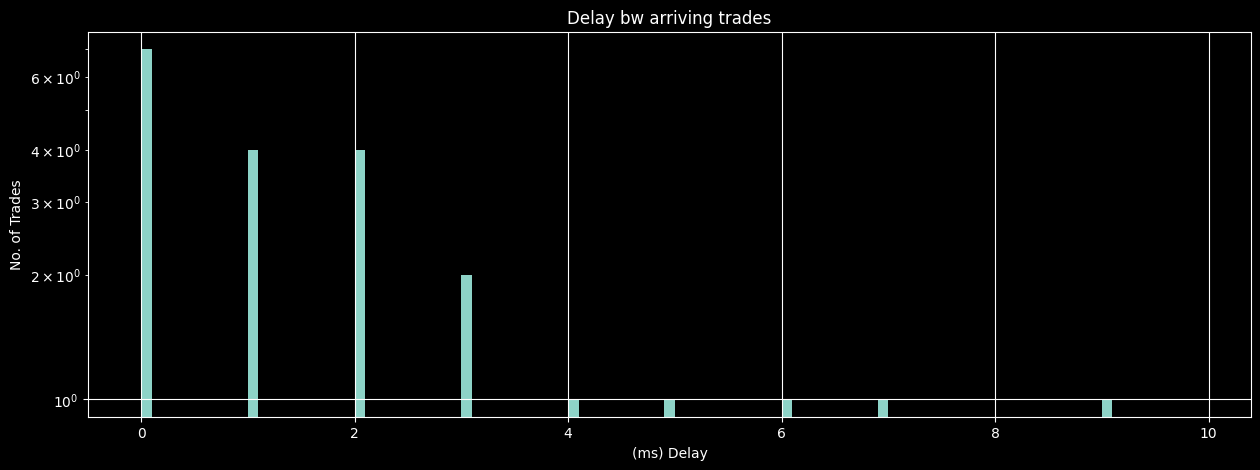

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
bins = np.arange(0, 10, 0.1)
dt.sort_values().diff().hist(bins=bins)  
plt.xlabel("(ms) Delay")
plt.ylabel("No. of Trades")
plt.yscale('log')
plt.title("Delay bw arriving trades")
plt.show()

In [ ]:
print( "Minimum non zero number of milliseconds: ", dt[dt>0].min())

Minimum non zero number of milliseconds:  1.0


In [ ]:
data[data.order_id=='130d7c98-c3dc-41d3-8ab4-a5357f5c23a9'][imp+['order_type']]

,price,remaining_size,side,type,reason,order_id,time,order_type
time,,,,,,,,
